In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib notebook

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
import datetime

import utils
import importlib
importlib.reload(utils)

double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [2]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)
print(df.shape)
y = df['relevant']
df.head()

(1984, 13)


,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date
0,2215,WOS:000372633900005,"Fitzpatrick, C, Engels, D",The Sustainable Development Goals (SDGs) have ...,"Fitzpatrick, C",192341,2018-09-21 16:02:18.885107+00:00,1,760,Leaving no one behind: a neglected tropical di...,Control; Elimination; Eradication; Monitoring;...,"['Public, Environmental & Occupational Health']",2018-09-21 16:02:18
1,2702,WOS:000362291900001,"Multari, S, Stewart, D, Russell, WR",Legumes have the potential to support global p...,"Multari, S",256798,2018-09-07 07:55:20.496101+00:00,1,737,Potential of Fava Bean as Future Protein Suppl...,animal feed; Fava bean; food ingredients; non-...,['Food Science & Technology'],2018-09-07 07:55:20
2,2952,WOS:000392308000012,"Nayebare, SR, Nayebare, SR, Aburizaiza, OS, Kh...","The present study describes the measurement, c...","Nayebare, SR",6533,2018-09-20 09:15:08.849837+00:00,1,760,Chemical Characterization and Source Apportion...,Black carbon; Trace elements; Enrichment facto...,['Environmental Sciences'],2018-09-20 09:15:08
3,991,WOS:000383555700001,"Fink, JR, Inda, AV, Tiecher, T, Barron, V",Continuous crop expansion has led to a growing...,"Fink, JR",627214,2018-09-21 08:00:54.071056+00:00,1,760,Iron oxides and organic matter on soil phospho...,Goethite; hematite; phosphorus adsorption; pho...,"['Agriculture, Multidisciplinary; Agronomy']",2018-09-21 08:00:54
4,45,WOS:000328467400006,"Whitsed, R, Davidson, P",International strategies to reduce the amount ...,"Whitsed, R",406195,2018-09-21 08:06:36.393773+00:00,1,753,Remote Assessment of Factors Influencing Housi...,Solar orientation; GIS; BASIX; housing thermal...,['Environmental Studies; Geography; Urban Stud...,2018-09-21 08:06:36


### The sample is unbalanced, with 22% negatives

<IPython.core.display.Javascript object>


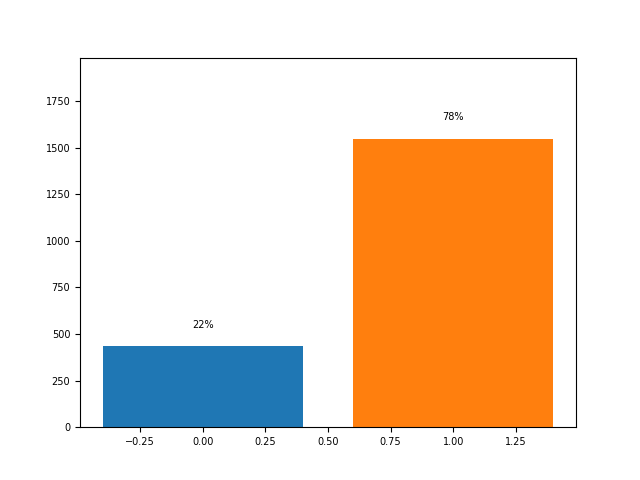

In [193]:
plt.close()
fig, ax = plt.subplots()
i = 0
for name, group in df.groupby('relevant'):
    s = group['id'].size
    plt.bar(i, s)
    plt.text(i, s + df['id'].size*0.05, "{:.0%}".format(s/df['id'].size),ha="center")
    i+=1
    
plt.ylim(0,df['id'].size)
#fig.tight_layout()
    
plt.show()
    

## Generating various feature collections for input

In [3]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=15, max_df=0.6, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X = vec.fit_transform(df['content'])
ab_X.shape

(1984, 2088)

In [4]:
vec = TfidfVectorizer(
    ngram_range=(1,3),
    min_df=5, max_df=0.8, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X_dense = vec.fit_transform(df['content'])
ab_X_dense.shape

(1984, 6368)

In [5]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.9, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)


ti_X = vec.fit_transform(df['title'])
ti_X.shape

(1984, 358)

In [198]:
# keywords
import re
def kw_tokenize(X):
    for x in X.split(';'):
        t = x.replace('[','').replace(']','').strip()
        t = t.replace("'","")
        t = re.sub('^, ','',t)
        t = t.replace(',,',',')
        if len(x) < 2:
            continue
        yield t

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
)
df['wosarticle__wc'] = df['wosarticle__wc'].fillna("")
wc_X = vec.fit_transform(df['wosarticle__wc'])
print(wc_X.shape)
vec.get_feature_names()[:5]

(1984, 162)


['agricultural economics & policy',
 'agricultural engineering',
 'agriculture, dairy & animal science',
 'agriculture, multidisciplinary',
 'agronomy']

In [199]:
# keywords

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
    #tokenizer=lambda x: x.split('; ')
)
df['wosarticle__de'] = df['wosarticle__de'].fillna("")
de_X = vec.fit_transform(df['wosarticle__de'])
print(de_X.shape)
vec.get_feature_names()[:5]

(1984, 323)


['activated carbon',
 'adaptation',
 'adsorption',
 'africa',
 'agricultural sustainability']

In [8]:
vec = CountVectorizer(
    ngram_range=(1,1),
    min_df=1, max_df=0.9, strip_accents='unicode', 
    stop_words="english",tokenizer=utils.tokenize
)
df['authors'] = df['authors'].fillna("")
au_X = vec.fit_transform(df['authors'])
print(au_X.shape)
vec.get_feature_names()[:5]

(1984, 5561)


['aa',
 'aalbersberg',
 'aall',
 'aanen',
 'aap',
 'abadia',
 'abate',
 'abbas',
 'abbasi',
 'abdelaziz',
 'abdessalaam',
 'abdolmohammadi',
 'abdu',
 'abdullah',
 'aboagye',
 'abonyi',
 'aboueshagh',
 'abourizk',
 'abrantes',
 'abriak',
 'abson',
 'abu',
 'abubakar',
 'aburizaiza',
 'acevedo',
 'ache',
 'achilefu',
 'achterberg',
 'ackerman',
 'ackermann',
 'acosta',
 'act',
 'adachi',
 'adam',
 'adamec',
 'adamek',
 'adas',
 'adawi',
 'adc',
 'addae',
 'adekanye',
 'adelabu',
 'adger',
 'adhikary',
 'adjei',
 'adkins',
 'aem',
 'affholder',
 'affinito',
 'aflaki',
 'afp',
 'afr',
 'afshar',
 'afzal',
 'agarwal',
 'agelii',
 'aghaei',
 'agnew',
 'agostinho',
 'agterbosch',
 'aguillo',
 'agustsson',
 'agut',
 'ahamed',
 'ahangari',
 'ahlin',
 'ahluwalia',
 'ahmad',
 'ahmadi',
 'ahmed',
 'ahn',
 'ai',
 'aihara',
 'aini',
 'airey',
 'aja',
 'ajd',
 'ajk',
 'ajms',
 'ajp',
 'akalin',
 'akbar',
 'akbari',
 'akbarian',
 'akbulut',
 'akh',
 'akhter',
 'akiyoshi',
 'akm',
 'akpagana',
 'akpav

In [9]:
X = X = hstack([ab_X,ti_X,wc_X,de_X],format="csr")
X.shape

(1984, 2931)

In [10]:
nmf = NMF(n_components=125,random_state=1,
          alpha=.1, l1_ratio=.5)

W = nmf.fit_transform(X)

## Testing the different feature collections with various models

In [11]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []

kf = KFold(n_splits=10)

for x in xs:
    print(x['title'])
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    for train_index, test_index in kf.split(X):
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
keywords
titles, abs,
kw, wc
titles, abs
topic_model_all


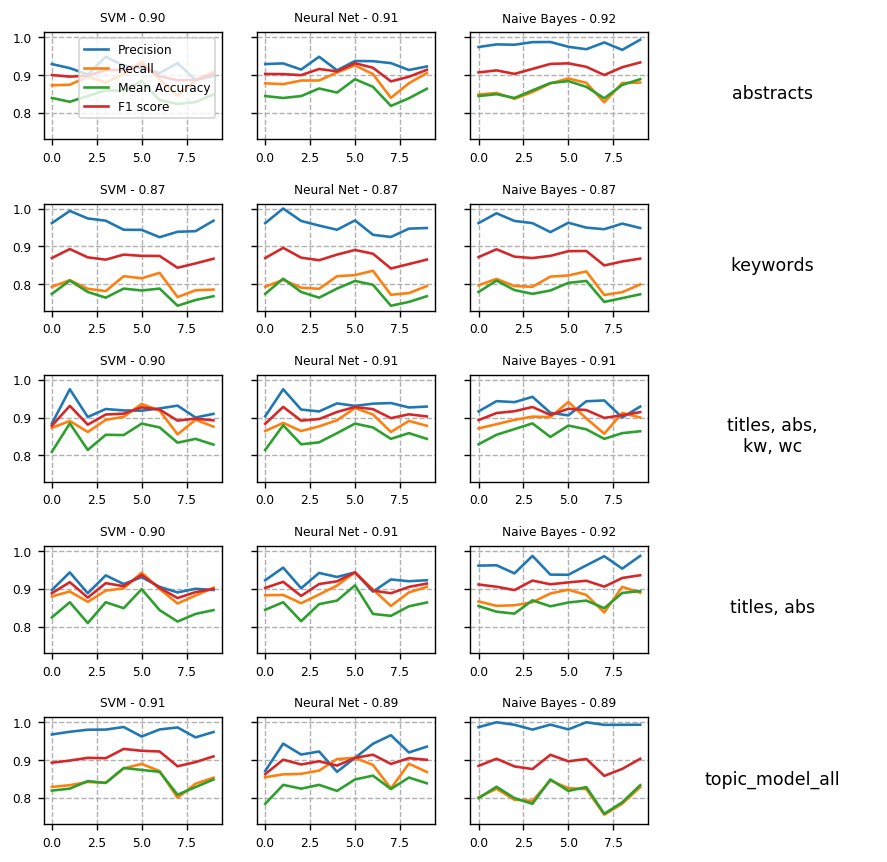

In [12]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['f'])))
        ax.grid()
    ax = axs[i,3]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
#plt.savefig("plots/model_comparison.png")


In [13]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []


for x in xs:
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    print(x['title'])
    for s in range(9):
        train = df.sample(frac=(s+1)*0.1).copy()
        test = df[~df['id'].isin(train['id'])].copy()
        train_index = train.index
        test_index = test.index
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
keywords
titles, abs,
kw, wc
titles, abs
topic_model_all


In [194]:
## Most models work fairly well even with small training sets

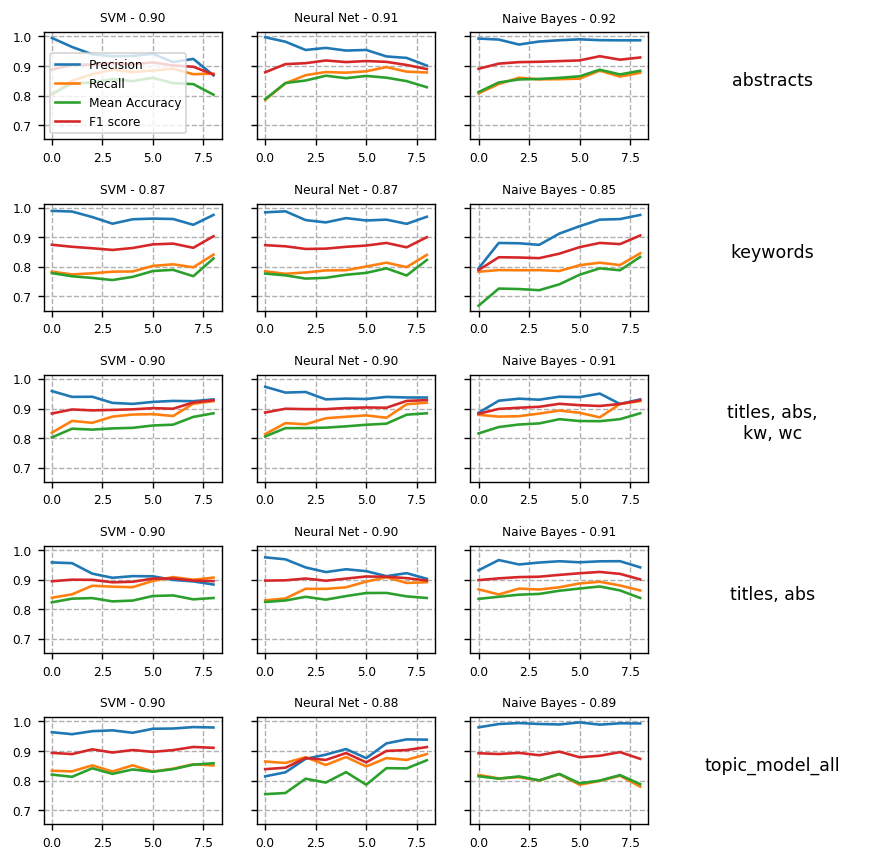

In [15]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['f'])))
        ax.grid()
    ax = axs[i,3]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
#plt.savefig("plots/model_comparison.png")


## By adjusting our probability threshold we can prioritise precision or recall

<IPython.core.display.Javascript object>


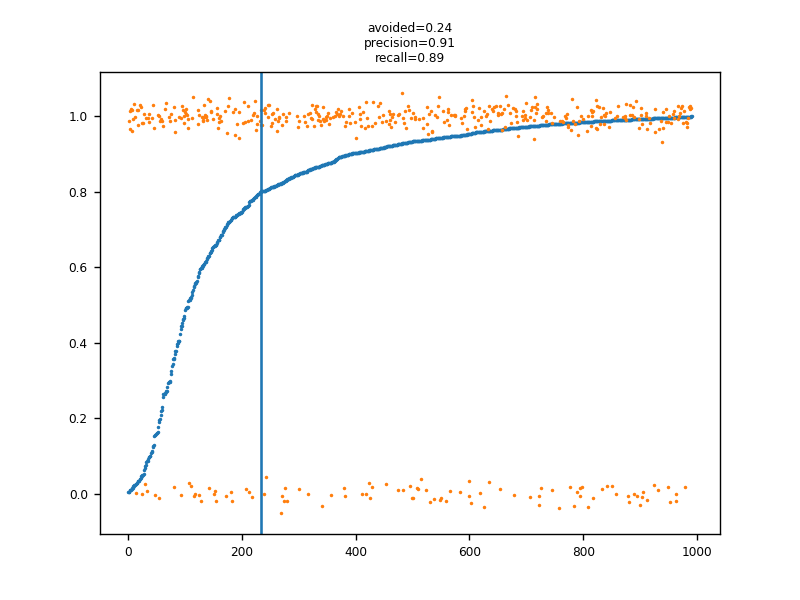

Accuracy: 0.86


/home/max/.local/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [195]:
importlib.reload(utils)

local_x = ab_X

train = df.sample(frac=0.5).copy()
test = df[~df['id'].isin(train['id'])].copy()

clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
clf = MultinomialNB(alpha=0.1) 

clf.fit(local_x[train.index],y[train.index])

fig, ax = plt.subplots(dpi=125)

print("Accuracy: {:.2f}".format(clf.score(local_x[test.index],y[test.index])))

utils.plot_model_accuracy(clf,local_x[test.index],y[test.index],ax, 0.8)

<IPython.core.display.Javascript object>


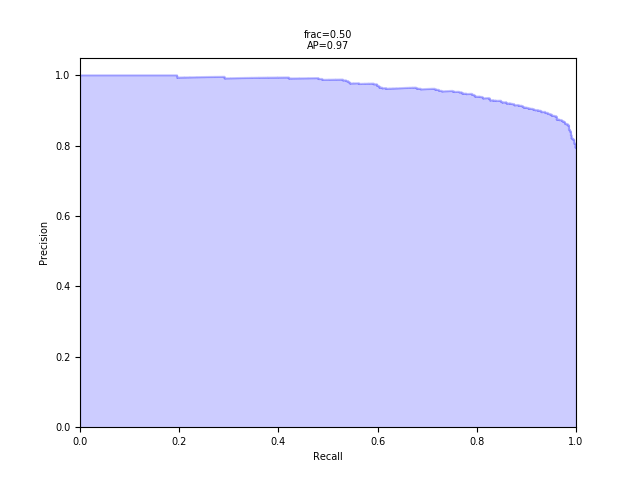

Average precision-recall score: 0.97


In [196]:
importlib.reload(utils)

fig, ax = plt.subplots()
utils.precision_recall_plot(clf,local_x[test.index],y[test.index],ax,0.5)

In [66]:
from sklearn.metrics import confusion_matrix

cnf = confusion_matrix(y[test.index],clf.predict(ab_X[test.index]))

<IPython.core.display.Javascript object>


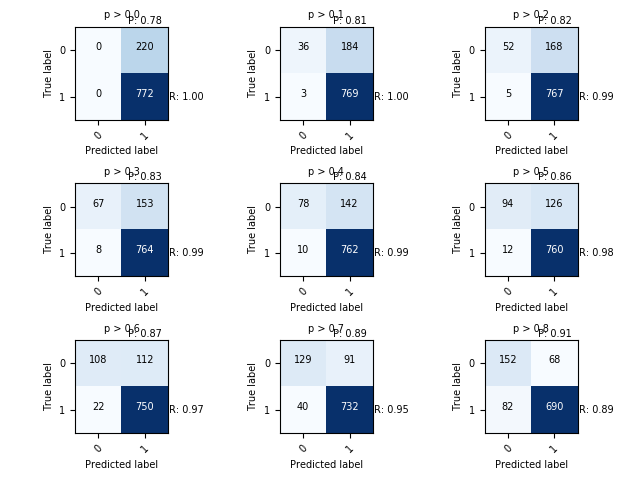

Confusion matrix, without normalization
[[  0 220]
 [  0 772]]
Confusion matrix, without normalization
[[ 36 184]
 [  3 769]]
Confusion matrix, without normalization
[[ 52 168]
 [  5 767]]
Confusion matrix, without normalization
[[ 67 153]
 [  8 764]]
Confusion matrix, without normalization
[[ 78 142]
 [ 10 762]]
Confusion matrix, without normalization
[[ 94 126]
 [ 12 760]]
Confusion matrix, without normalization
[[108 112]
 [ 22 750]]
Confusion matrix, without normalization
[[129  91]
 [ 40 732]]
Confusion matrix, without normalization
[[152  68]
 [ 82 690]]


In [197]:
y_prob = clf.predict_proba(local_x[test.index])[:,1]
t = 0.1
y_pred = np.where(y_prob>t,1,0)
fig = plt.figure()
for i in range(9):
    t = i*0.1
    y_pred = np.where(y_prob>t,1,0)
    ax = fig.add_subplot(3,3,i+1)
    cnf = confusion_matrix(y[test.index],y_pred)
    plot_confusion_matrix(cnf,classes=[0,1])
    ax.set_title("p > {:.1f}".format(t))

#plt.colorbar()
    
fig.tight_layout()

## False positives and false negatives

In [17]:
test['predicted'] = clf.predict(ab_X[test.index])
test['prob'] = clf.predict_proba(ab_X[test.index])[:,1]
fps = test[test['predicted']-test['relevant']==1].sort_values('prob',ascending=False)

fps.head()

,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date,predicted,prob
274,788,WOS:000257628400009,"Macher, C, Guyader, O, Talidec, C, Bertignac, M",The Nephrops trawl fishery is one of the most ...,"Macher, C",686419,2018-09-24 04:24:08.321493+00:00,0,753,A cost-benefit analysis of improving trawl sel...,Nephrops norvegicus; bio-economic simulations;...,['Fisheries'],2018-09-24 04:24:08,1,0.987921
948,288,WOS:000386601100008,"Hove, T, Derman, B, Manzungu, E",Zimbabwe's water reforms that were undertaken ...,"Hove, T",686749,2018-09-24 04:39:35.844317+00:00,0,760,"Land, Farming and IWRM: A Case Study of the Mi...",Water reform; land reform; agriculture; IWRM; ...,['Environmental Studies; Water Resources'],2018-09-24 04:39:35,1,0.979540
315,1405,WOS:000206559700002,"Chen, W, Sun, W, Xiang, JB",The second-tier extended metropolises in the C...,"Chen, W",625421,2018-09-20 08:55:29.898600+00:00,0,753,GROWTH OF NEW ECONOMIC SECTORS IN SECOND-TIER ...,second-tier extended cities; new economic sect...,['Environmental Sciences'],2018-09-20 08:55:29,1,0.966764
1575,1350,WOS:000329036700026,"Cheng, L, Sheahan, AJ, Gibbs, SJ, Rius, AG, Ka...",The objective of this study was to investigate...,"Cheng, L",184695,2018-09-21 13:41:12.748271+00:00,0,753,Technical note: Nitrogen isotopic fractionatio...,nitrogen-15; rumen degradable protein; sustain...,"['Agriculture, Dairy & Animal Science']",2018-09-21 13:41:12,1,0.966064
1963,2030,WOS:000350986300003,"Pienaar, L, von Fintel, D",Just more than one hundred years after the imp...,"Pienaar, L",194431,2018-09-20 07:58:16.841950+00:00,0,753,HUNGER IN THE FORMER APARTHEID HOMELANDS: DETE...,hunger; subsistence farming; apartheid homelan...,['Agricultural Economics & Policy'],2018-09-20 07:58:16,1,0.964229


In [21]:
print('#########\nFALSE POSITIVES')

for i, row in fps.head(5).iterrows():
    print('\n####')
    print(row['title'])
    print("predicted: {:.2}, rated: {}".format(row['prob'],row['relevant']))
    print(row['content'])

#########
FALSE POSITIVES

####
A cost-benefit analysis of improving trawl selectivity in the case of discards: The Nephrops norvegicus fishery in the Bay of Biscay
predicted: 0.99, rated: 0
The Nephrops trawl fishery is one of the most important fisheries in the Bay of Biscay. The fishery management essentially relies on conservation measures, a total at I owed catch (TAC) for Nephrops together with a mini mum landing size (MLS) and minimum trawl mesh size (70 mm stretched mesh). These measures have failed to prevent high discard levels of many species that characterize the fishery. Nephrops trawlers thus discard about half of their Nephrops catches in numbers (a third in weight) of which only 30% survive. Nephrops discards mainly occur in younger Nephrops age groups below the MLS. This is a waste for the already overexploited Nephrops stock as well as for the fleet. Based on a bio-economic simulation model, the paper analyses the consequences of several scenarios of improving Nephrop

In [19]:
fns = test[test['predicted']-test['relevant']==-1].sort_values('prob')

fns.head()

,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date,predicted,prob
1073,1286,WOS:000340466400013,"Tacon, CE, Abbas, H, Zhang, SY, Nicholls, B, C...",Clinical research bridges patients' unmet medi...,"Tacon, CE",597641,2018-09-21 11:28:04.709797+00:00,1,760,Trends in Canadian respiratory clinical trials...,Canada; Clinical trials; Respiratory,['Respiratory System'],2018-09-21 11:28:04,0,0.021505
1218,564,WOS:000374156600002,"Agarwal, R, Green, R, Agarwal, N, Randhawa, K",Purpose - The purpose of this paper is to inve...,"Agarwal, R",413540,2018-09-21 04:49:45.436555+00:00,1,753,Benchmarking management practices in Australia...,Performance management; Management; Human reso...,['Health Policy & Services'],2018-09-21 04:49:45,0,0.083801
475,1025,WOS:000381137800018,"Darmstadt, GL, Howson, CP, Walraven, G, Armstr...",As the Sustainable Development Goals are adopt...,"Darmstadt, GL",111228,2018-09-21 02:37:47.255744+00:00,1,753,Prevention of Congenital Disorders and Care of...,,['Pediatrics'],2018-09-21 02:37:47,0,0.142566
1861,2858,WOS:000297583000002,"Mundell, JP, Visser, MJ, Makin, JD, Kershaw, T...",The authors of this study evaluated a structur...,"Mundell, JP",292281,2018-09-21 12:48:09.192878+00:00,1,760,The Impact of Structured Support Groups for Pr...,HIV/AIDS; mental health; pregnancy; psychosoci...,"[""Public, Environmental & Occupational Health;...",2018-09-21 12:48:09,0,0.163216
22,3075,WOS:000306201600009,"Welling, RD, Azene, EM, Kalia, V, Pongpirul, K...",The 2010 RAD-AID Conference on International R...,"Welling, RD",533058,2018-09-19 18:58:04.820409+00:00,1,753,White Paper Report of the 2010 RAD-AID Confere...,Radiology; developing countries; public health...,"['Radiology, Nuclear Medicine & Medical Imaging']",2018-09-19 18:58:04,0,0.186688


In [22]:
print('#########\nFALSE NEGATIVES')

for i, row in fns.head(5).iterrows():
    print('\n####')
    print(row['title'])
    print("predicted: {:.2}, rated: {}".format(row['prob'],row['relevant']))
    print(row['content'])

#########
FALSE NEGATIVES

####
Trends in Canadian respiratory clinical trials from 2001 to 2011
predicted: 0.022, rated: 1
Clinical research bridges patients' unmet medical need with innovative medicines, increases knowledge acquisition by clinicians, and creates solutions to improve the sustainability and quality of the Canadian health care system and economy. The Canadian Institutes of Health Research and the Canadian Lung Association have recently raised concerns over declining research activities within the Canadian respiratory community. While there are currently > 3000 ongoing clinical trials in Canada, the number of trials investigating common respiratory diseases is unknown. The objective of the present study was to monitor the trends in industry-and non-industry-sponsored respiratory clinical trials in Canada from 2001 to 2011. Trialtrove 2012 (Citeline, an Informa UK business), a database containing summarized clinical trial information regarding pharmaceutical products, was

## Todos:
- Ensemble methods
- Error overlap
- category exclusion